In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, confusion_matrix

In [2]:
df = pd.read_csv("../../3_variant_nasa_danger_objects/input/v1_first_collection_2021.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB
None


In [3]:
# Fortunately, there do not appear to be any missing values. Because we wish to predict "hazardous," let's do a quick check to see if "hazardous" is imbalanced.
print("Proportion of Hazardous N.E.O.'s")
print(df["hazardous"].value_counts() / len(df))

Proportion of Hazardous N.E.O.'s
False    0.902682
True     0.097318
Name: hazardous, dtype: float64


In [4]:
# This is less extreme than I expected. About 9% of all recorded N.E.O's are hazardous. This is not a high percentage, but perhaps higher than we would like it to be. Let's check the number of unique values across other columns.
print(df.nunique())

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64


In [5]:
# A couple of thoughts here:
#
# Because "orbiting_body" and "sentry_object" only have 1 value, they are useless from a modeling standpoint.
# Interestingly, there are many thousands of non-unique id's and names. This suggests the same N.E.O's are being sampled over time, with potential different values for the other variables being recorded.
# Another suspicious set of variables is "est_diameter_min" and "dst_diameter_max." Do we need both of these variables?
# Let's start by figuring out what's going on with the "id" variable. If the same N.E.O.'s are being sampled over time, we might be able to use past information to predict the future hazardous state of a N.E.O..
# groups observations by id, then sums the hazardous column

grouped = df.groupby("id").sum()["hazardous"]

# this is a binary variable that measure whether there are more than one hazardous observation for that id
df["prev_hazard"] = df.apply(lambda row: grouped[row["id"]] > 1, axis="columns")

c = df["prev_hazard"].corr(df["hazardous"], method="spearman")
print("Spearman Correlation Between \"prev_hazard\" and \"hazardous\":\n")
print(c)

print("\n\"hazardous\" N.E.O's grouped by \"prev_hazard\"\n")
print(df.groupby("prev_hazard").sum()["hazardous"])


Spearman Correlation Between "prev_hazard" and "hazardous":

0.9716803297473297

"hazardous" N.E.O's grouped by "prev_hazard"

prev_hazard
False     448
True     8392
Name: hazardous, dtype: int64


In [6]:
# Around 8,000 hazardous N.E.O's are "prev_hazardous"--meaning that they have already been recorded as hazardous. Only about 450 N.E.O.'s are false for "prev_hazard"--or the only observation of that id to be hazardous. What this means is that of hazardous N.E.O's, it's very likely that there are multiple observations for that object.
#
# We can now turn to an analysis of "est_diameter_min" and "est_diameter_max."

# using spearman correlation over pearson's R
# spearman's correlation doesn't assume linear relationship

print("Spearman Correlations with est_diameter_min\n")
print(df.corr(method="spearman")["est_diameter_min"])

Spearman Correlations with est_diameter_min

id                   -0.500122
est_diameter_min      1.000000
est_diameter_max      1.000000
relative_velocity     0.335507
miss_distance         0.269061
sentry_object              NaN
absolute_magnitude   -1.000000
hazardous             0.374830
prev_hazard           0.363730
Name: est_diameter_min, dtype: float64


In [7]:
# This is very interesting. Not only are "est_diameter_min" and "est_diameter_max" perfectly correlated, "est_diameter_min" is also perfectly negatively correlated with "absolute_magnitude"! These numbers suggest that we only need one of these variables. I'll keep absolute_magnitude.
print("Spearman Correlations with est_diameter_min\n")
print(df.corr(method="spearman")["hazardous"])

Spearman Correlations with est_diameter_min

id                   -0.262851
est_diameter_min      0.374830
est_diameter_max      0.374830
relative_velocity     0.183875
miss_distance         0.043024
sentry_object              NaN
absolute_magnitude   -0.374830
hazardous             1.000000
prev_hazard           0.971680
Name: hazardous, dtype: float64


In [8]:
yColumn = ["hazardous"]
xColumns = ["relative_velocity", "absolute_magnitude", "miss_distance", "prev_hazard"]
df = df[xColumns + yColumn]


df.describe().round(2)

,relative_velocity,absolute_magnitude,miss_distance
count,90836.00,90836.00,90836.00
mean,48066.92,23.53,37066546.03
std,25293.30,2.89,22352040.60
min,203.35,9.23,6745.53
25%,28619.02,21.34,17210820.24
50%,44190.12,23.70,37846579.26
75%,62923.60,25.70,56548996.45
max,236990.13,33.20,74798651.45


# Distribution Comparisons
This section shows grouped distributions of the continuous columns with "hazardous." Compared to "prev_hazard", these columns aren't as strong of predictors of "hazardous."

In [9]:
# let's start grouping everything by hazardous

nHz = df[(df["hazardous"] == False)]
hz = df[(df["hazardous"] == True)]

# function to show the hazardous and non-hazardous distributions of a variable
def compare_dist_hazard(columnName):

    f, ax = plt.subplots(figsize=(6, 5))

    ax = sns.kdeplot(nHz[columnName], ax=ax, color="tab:blue", label="Not Hazardous")
    ax = sns.kdeplot(hz[columnName], ax=ax, color="tab:orange", label="Hazardous")

    ax.set_xlabel("")
    ax.set_yticklabels([])
    ax.set_title(columnName + " grouped by hazardous")
    ax.legend()
    plt.show()

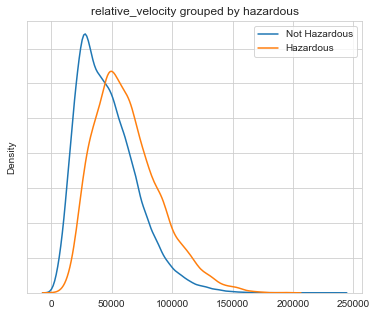

In [10]:
compare_dist_hazard("relative_velocity")

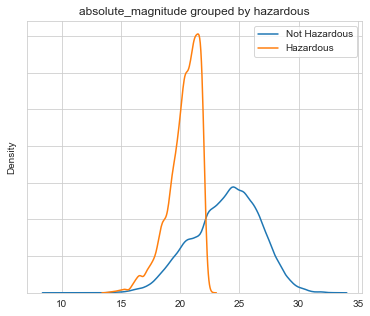

In [11]:
compare_dist_hazard("absolute_magnitude")

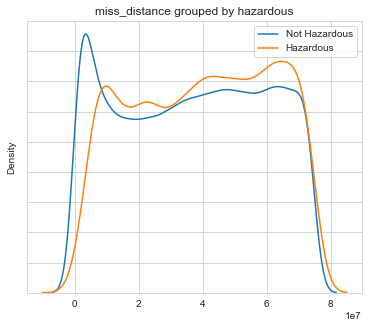

In [12]:
compare_dist_hazard("miss_distance")

# K-Fold Cross Validation Model Scouting

In [13]:
y = df["hazardous"]
X = df.drop("hazardous", axis="columns")


# function to conduct k fold cross validation on estimator
def cross_validate(estimatorName, estimator):

    # this is a pipeline to scale the data, then fit the given estimator
    pipe = Pipeline([("scalar", StandardScaler()), (estimatorName, estimator)])

    # because our y vector is imbalanced, this stratified k fold cross validator
    # ensures that none of the folds has too little of hazardous N.E.O.s
    skf = StratifiedKFold(n_splits=5)

    # conducts k-fold cross validation with stratified cross validator
    scores = cross_val_score(pipe, X, y, scoring="recall", cv=skf)

    # outputs results
    print(estimatorName)
    print("")
    print("Average Recall: ", np.mean(scores))
    print("Standard Deviation: ", np.std(scores))

#### Using recall as our scoring metric. This is because "hazardous" is an imbalanced class and because we care much more about avoiding false negatives than false positives. In other words, we would rather have a N.E.O. wrongly classified as "hazardous" than "not hazardous."

In [14]:
knn = KNeighborsClassifier(weights="distance")
cross_validate("K-Nearest Neighbors", knn)

K-Nearest Neighbors

Average Recall:  0.9561085972850678
Standard Deviation:  0.005288990826950676


## Random Forest Cls

In [15]:
rfc = RandomForestClassifier()
cross_validate("Random Forest", rfc)

Random Forest

Average Recall:  0.9593891402714932
Standard Deviation:  0.005465100601439458


# Decision Tree

In [16]:
tree = DecisionTreeClassifier()
cross_validate("Decision Tree", tree)

Decision Tree

Average Recall:  0.9618778280542987
Standard Deviation:  0.005313130572768026


# Decision Tree Hyper Param Tuning

In [17]:
def grid_search(estimator, estimatorName, params_dict):
    # this is a pipeline to scale the data, then fit the given estimator
    pipe = Pipeline([("scalar", StandardScaler()), (estimatorName, estimator)])

    # because our y vector is imbalanced, this stratified k fold cross validator
    # ensures that none of the folds has too little of hazardous N.E.O.s
    skf = StratifiedKFold(n_splits=5)

    grid = GridSearchCV(pipe, params_dict, scoring="recall", cv=skf)
    grid.fit(X, y)


    print("Best Params: ", grid.best_params_)
    print("Best Recall: ", grid.best_score_)


search_dict = {"tree__criterion": ["gini", "entropy"],
              "tree__max_depth": [None, 5, 10],
              "tree__min_samples_split": [2, 5, 10],
              }

In [18]:
search_tree = DecisionTreeClassifier()
grid_search(search_tree, "tree", search_dict)

Best Params:  {'tree__criterion': 'gini', 'tree__max_depth': None, 'tree__min_samples_split': 5}
Best Recall:  0.9623303167420815


# Feature Importance and Final Metrics

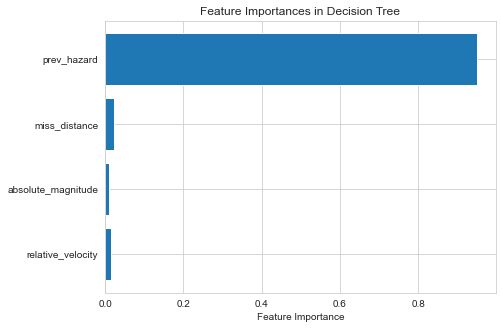

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

final_model = DecisionTreeClassifier(criterion="gini", min_samples_split=5)
final_model.fit(X_train, y_train)

feature_names = final_model.feature_names_in_
feature_importances = final_model.feature_importances_

f, ax = plt.subplots(figsize=(7, 5))
ax.barh(range(len(feature_importances)), feature_importances)
ax.set_yticks(range(len(feature_importances)))
ax.set_yticklabels(feature_names)
ax.set_title("Feature Importances in Decision Tree")
ax.set_xlabel("Feature Importance")
plt.show()

In [21]:
final_model.score(X_test, y_test)

0.9922497688141265